# Curso Deep Learning

<img src="https://yaelmanuel.com/wp-content/uploads/2021/12/platzi-banner-logo-matematicas.png" width="500px">

---

## Creando nuestro propio Churn Analysis 🤓📊

En este lab aprenderás:

* [Tensorflow](https://www.tensorflow.org/)
* [Keras](https://keras.io/)
* Descargar un dataset, prepararlo, entrenarlo, realizar finetuning y guardarlo.


### 1) Descarga del dataset 🤓

Utilizaremos un conjunto de datos de un proveedor de Telecomunicaciones para su Programa de Retención.
<br>Para más detalle acá se puede ver el dataset de Kaggle: [Telco Customer Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data).


In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list -s telco-customer-churn

In [ ]:
!kaggle datasets download -d blastchar/telco-customer-churn

In [ ]:
!unzip '/content/telco-customer-churn.zip'

### 2) Preparación de la data 👌

#### 2.1) Instalamos las dependencias 🙌

In [ ]:
!pip install ydata-profiling

In [ ]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

#### 2.2) Explorar Dataset 🔍

In [ ]:
!ls

In [ ]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv", sep=",")

**Tip:** Para visualizar todas las columnas del dataframe

In [ ]:
df.head(3)

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df.head(3)

#### 2.3) EDA (Análisis Exploratorio de Datos)

Visualizamos qué tenemos en el dataframe

In [ ]:
# Crear un resumen utilizando funciones nativas de pandas
def summarize_dataframe_with_pandas(df):
    summary = df.describe(include='all').T  # Descripción general
    summary['Type'] = df.dtypes  # Tipos de datos
    summary['Unique Values'] = df.nunique()  # Cantidad de valores únicos
    summary['Examples'] = df.apply(lambda col: col.dropna().unique()[:3])  # Ejemplos de valores

    # Reorganizar columnas para mejor visualización
    summary = summary[['Type', 'Unique Values', 'Examples']]
    return summary

In [ ]:
summarize_dataframe_with_pandas(df)

Una visualización más detallada e interactiva

In [ ]:
from ydata_profiling import ProfileReport

ProfileReport(df, minimal=True)

#### 2.4) Valores únicos

Eliminar columna con valores únicos

In [ ]:
df = df.drop('customerID', axis=1)

Eliminar columna con que puede generar Bias o Sesgo

In [ ]:
df = df.drop('gender', axis=1)

#### 2.5) Valores faltantes

In [ ]:
# Evaluar cantidad de valores faltantes
df.isnull().sum()

#### 2.6) Columnas Categóricas

Reeplazo de valores binarios en columnas categóricas

In [ ]:
# Evitar warning por uso de Replace
pd.set_option('future.no_silent_downcasting', True)

In [ ]:
categorical_columns = list(df.select_dtypes(include='O').keys())

for i in categorical_columns:
    df[i] = df[i].replace('Yes', 1)
    df[i] = df[i].replace('No', 0)

Label Encoder

In [ ]:
# Inicializar y aplicar LabelEncoder único
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # Codificar las columnas categóricas
    label_encoders[col] = le  # Guardar el codificador único para cada columna

In [ ]:
# Guardar los label encoders
joblib.dump(label_encoders, 'label_encoders.pkl')

#### 2.7) Columnas Numéricas

Escalar la data

In [ ]:
scale_cols = ['tenure','MonthlyCharges','TotalCharges']

scale = MinMaxScaler()
df[scale_cols] = scale.fit_transform(df[scale_cols])

In [ ]:
# Guardar el escalado de datos
joblib.dump(scale, 'scaler.pkl')

### 3) Entrenamiento 💪

In [ ]:
x = df.drop('Churn', axis=1)
y = df['Churn']

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2)

print(xtrain.shape, ytrain.shape)

In [ ]:
print(xtest.shape, ytest.shape)

### 4) Red Neuronal 😨

In [ ]:
# Obtener el número de columnas de entrenamiento
num_columns = 18

In [ ]:
model = keras.Sequential([
    keras.layers.Input(shape=(num_columns,)),  # Capa de entrada con 18 características
    keras.layers.Dense(16, activation='relu'), # Primera capa oculta
    keras.layers.Dense(1, activation='sigmoid') # Capa de salida
])

**Explicación de porqué 16 neuronas:**

- **Entrada:** El modelo utiliza 18 características.
- **16 neuronas:** Elegido por ser cercano al número de características, siguiendo buenas prácticas iniciales.
- **Balance:** Simple, funcional y eficiente para entrenamiento rápido.
- **Base ajustable:** Diseñado para optimización futura con herramientas como KerasTuner.

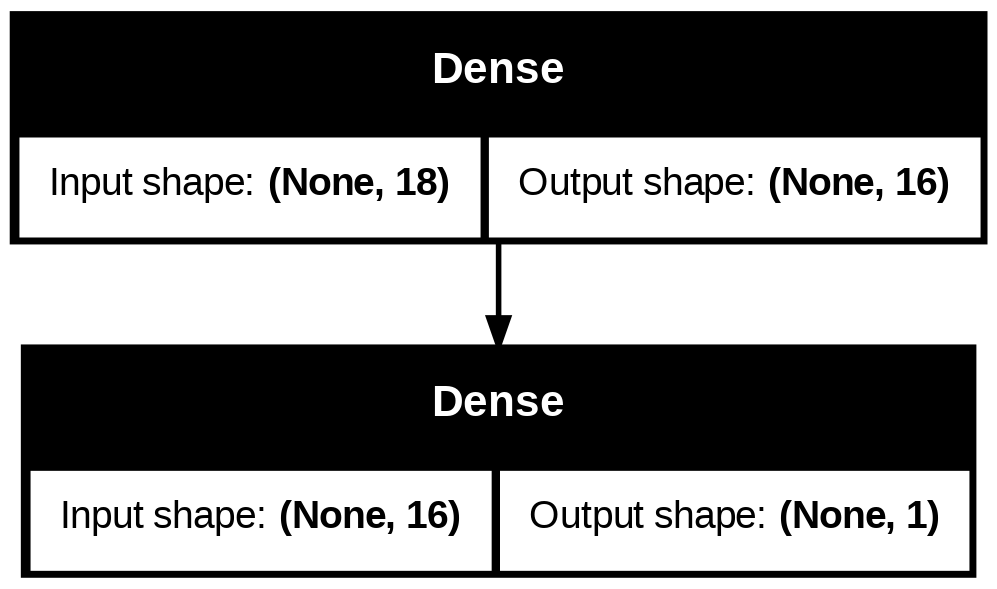

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss = 'binary_crossentropy')

**Probamos con 10 epochs**

In [ ]:
history = model.fit(xtrain, ytrain, epochs=10, validation_data=(xtest, ytest))

Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3967 - val_loss: 0.4230
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4038 - val_loss: 0.4237
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4139 - val_loss: 0.4233
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3892 - val_loss: 0.4241
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3857 - val_loss: 0.4237
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3993 - val_loss: 0.4253
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3868 - val_loss: 0.4238
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4015 - val_loss: 0.4246
Epoch 9/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4164 - val_loss: 0.4259
Epoch 10/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4022 - val_loss: 0.4242


### 5) Métricas 📊

### 6) Guardar el modelo 💾

### 7) Hacer Predicciones en Producción 🤙

### 8) Conclusiones

- Aprender sobre los distintos objetos y métodos que nos ofrece Tensorflow + Keras.

- Realizar el proceso completo de entrenamiento de un modelo con Tensorflow + Keras.

- Aprender tips sobre implementación con el uso de la GPU.

<br>
<br>
<br>

---

<br>
<br>


<img src="https://static.platzi.com/media/avatars/platziteam_8cfe6fc7-1246-4c9a-9f5d-d10d467443ee.png" width="100px">

[Platzi](https://platzi.com/) 🚀

